#CSC528 Assignment 3

##Alex Teboul

Helpful Resources:

* [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html
)


##Problem 1: Expectation Maximization

This problem comes (approximately) from Chapter 17 of the Forsyth book: create a Gaussian mixture model using expectation maximization to segment an image.  You are allowed to manually specify how many Gaussians you will have in the final result. (Easiest case to test might be 2: foreground and background; you might want to experiment with larger numbers to reflect more objects in the image.)  You need only do this for single parameter images (gray-scale), although you can use color if you wish (harder).  Do not use existing packages.  Think of this as fitting a Gaussian mixture model to the image histogram: we don’t care about where the pixel is (although we could); we only care about intensities and their probabilities.

You might also look at the Wikipedia article on mixture modeling (https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model).  Brilliant.org also had a nice read on Gaussian mixture modelling (https://brilliant.org/wiki/gaussian-mixture-model/)
Try your algorithm on an image of your choice.  Provide me the original image and an image with pixels labeled by Gaussian model to which they belonged.  (You can use color or grayscale to do the labelling.)
Put all your work into a single file: all images and program code.  Submit using the dropbox in D2L.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Get the Image(s)

In [0]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read in my image
img = cv2.imread("/content/gdrive/My Drive/A3-images/appleorange.jpg")  

In [0]:
#Bring it different images to test ------------------

#apple-orange example
rgb_ao = cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/A3-images/appleorange.jpg"),cv2.COLOR_BGR2RGB)
gray_ao = cv2.imread("/content/gdrive/My Drive/A3-images/appleorange.jpg",cv2.IMREAD_GRAYSCALE)  

#astro example
rgb_as = cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/A3-images/astro.jpg"),cv2.COLOR_BGR2RGB)
gray_as = cv2.imread("/content/gdrive/My Drive/A3-images/astro.jpg",cv2.IMREAD_GRAYSCALE)  

#castle example
rgb_ca = cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/A3-images/castle.jpg"),cv2.COLOR_BGR2RGB)
gray_ca = cv2.imread("/content/gdrive/My Drive/A3-images/castle.jpg",cv2.IMREAD_GRAYSCALE)  

#astro2 example
rgb_p = cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/A3-images/person.jpg"),cv2.COLOR_BGR2RGB)
gray_p = cv2.imread("/content/gdrive/My Drive/A3-images/person.jpg",cv2.IMREAD_GRAYSCALE)  

In [0]:
# Resize the images in case necessary
gray_ao2 = cv2.resize(gray_ao, (256,256), interpolation = cv2.INTER_CUBIC)
gray_as2 = cv2.resize(gray_as, (256,256), interpolation = cv2.INTER_CUBIC)
gray_ca2 = cv2.resize(gray_ca, (256,256), interpolation = cv2.INTER_CUBIC)
gray_p2 = cv2.resize(gray_p, (256,256), interpolation = cv2.INTER_CUBIC)

###Display Image

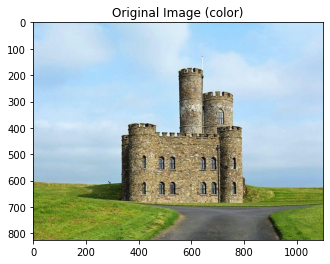

In [0]:
#Display image
plt.title("Original Image (color)")
plt.imshow(rgb_ca)

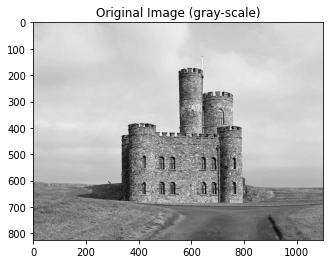

In [0]:
plt.title("Original Image (gray-scale)")
plt.imshow(gray_ca, cmap="gray")

(array([1.62800e+03, 1.30600e+03, 2.15000e+03, 2.70400e+03, 3.31700e+03,
        4.36400e+03, 4.23100e+03, 4.58300e+03, 5.38800e+03, 4.74300e+03,
        6.62500e+03, 7.26300e+03, 8.47600e+03, 1.28250e+04, 1.35140e+04,
        1.80870e+04, 2.88530e+04, 2.87880e+04, 3.21730e+04, 2.67800e+04,
        2.53020e+04, 2.62150e+04, 1.80290e+04, 1.44270e+04, 1.36500e+04,
        9.53400e+03, 9.37900e+03, 1.08750e+04, 1.49260e+04, 2.57920e+04,
        2.37420e+04, 3.94410e+04, 1.13916e+05, 1.64871e+05, 1.17263e+05,
        4.85790e+04, 1.24300e+04, 8.18000e+02, 3.52000e+02, 1.61000e+02]),
 array([  0.   ,   6.375,  12.75 ,  19.125,  25.5  ,  31.875,  38.25 ,
         44.625,  51.   ,  57.375,  63.75 ,  70.125,  76.5  ,  82.875,
         89.25 ,  95.625, 102.   , 108.375, 114.75 , 121.125, 127.5  ,
        133.875, 140.25 , 146.625, 153.   , 159.375, 165.75 , 172.125,
        178.5  , 184.875, 191.25 , 197.625, 204.   , 210.375, 216.75 ,
        223.125, 229.5  , 235.875, 242.25 , 248.625, 255.  

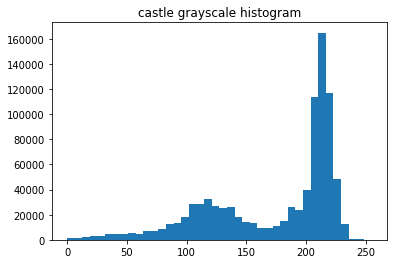

In [0]:
#The castle image has 2 gaussians on the other hand
plt.title("castle grayscale histogram")
plt.hist(gray_ca.ravel(), bins=40)

### Start EM and Gaussian Mixture Modeling

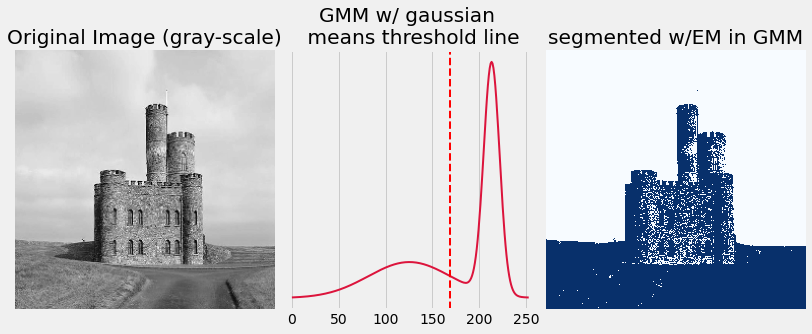

In [0]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

#select image
img = gray_ca2
hist, bin_edges = np.histogram(img, bins=40)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

#classify model points with gaussian mixture model of 2 components
model = GaussianMixture(n_components=2)
model.fit(img.reshape((img.size, 1)))

# Evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(model.score_samples(gmm_x.reshape(-1,1)))

#threshold - since there are only 2 components, pixel intensities below the threshold are dropped
threshold = np.mean(model.means_)
GMM_selected_img = img < threshold

#plot original gray-scale image----
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.title("Original Image (gray-scale)")
plt.imshow(gray_ca2, cmap="gray")
plt.axis('off')

#plot gaussian model
plt.subplot(132)
plt.title("GMM w/ gaussian \n means threshold line")
plt.plot(gmm_x, gmm_y, color="crimson", lw=2)
#this is the threshold line. Such that 
plt.axvline(169, color='r', ls='--', lw=2)

#plot image by gaussian model values
plt.yticks([])
plt.subplot(133)
#plt.imshow(GMM_selected_img, cmap='Blues')
plt.title("segmented w/EM in GMM")
plt.imshow(GMM_selected_img, cmap='Blues', interpolation='nearest') #This makes it binary
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

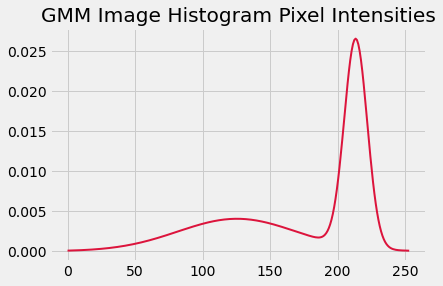

In [0]:
# Plot histograms and gaussian curves
fig, ax = plt.subplots()
plt.title("GMM Image Histogram Pixel Intensities")
ax.plot(gmm_x, gmm_y, color="crimson", lw=2)

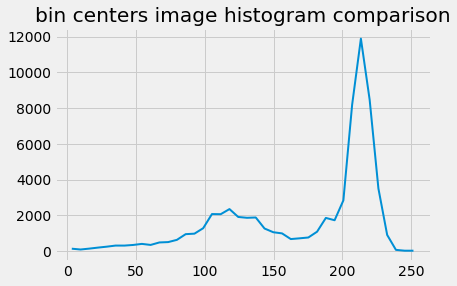

In [0]:
plt.title("bin centers image histogram comparison")
plt.plot(bin_centers, hist, lw=2)

In [0]:
#So I cut out pixels above the threshold because those belonged to the sky. This way land is selected based on the first gaussian.
# I assumed the mean of the gaussian means is the point of difference between the two gaussians.
threshold

169.4227507441844

### Trying to do w/o Package